In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
years = [2023,2022]
aqi_files = {
    2023:"/Users/shishir/Downloads/cs667-project/AQI DATA/AQI_daily_city_level_kanpur_2023_kanpur_2023.xlsx",
    2022: "/Users/shishir/Downloads/cs667-project/AQI DATA/AQI_daily_city_level_kanpur_2022_kanpur_2022.xlsx",
}
pollutant_files = {
    2023:"/Users/shishir/Downloads/cs667-project/POLLUTANT DATA/Raw_data_1Day_2023_site_5500_FTI_Kidwai_Nagar_Kanpur_UPPCB_1Day.csv",
    2022: "/Users/shishir/Downloads/cs667-project/POLLUTANT DATA/Raw_data_1Day_2022_site_5500_FTI_Kidwai_Nagar_Kanpur_UPPCB_1Day.csv",
  
}
merged_yearly_data = []

month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, 
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}
for year in years:
    
    aqi_data = pd.read_excel(aqi_files[year])
    pollutant_data = pd.read_csv(pollutant_files[year])

    pollutant_data['Timestamp'] = pd.to_datetime(pollutant_data['Timestamp'])
    pollutant_data.set_index('Timestamp', inplace=True)
    pollutant_data_interpolated = pollutant_data.interpolate(method='time')


    aqi_data = aqi_data.rename(columns={"Date": "Day"})
    aqi_long = pd.melt(aqi_data, id_vars=['Day'], var_name='Month', value_name='AQI')
    aqi_long['Month'] = aqi_long['Month'].map(month_mapping)
    aqi_long['Year'] = year

    aqi_long = aqi_long.dropna(subset=['Day', 'Month', 'Year'])  
    aqi_long['Day'] = pd.to_numeric(aqi_long['Day'], errors='coerce')
    aqi_long['Month'] = pd.to_numeric(aqi_long['Month'], errors='coerce')
    aqi_long['Year'] = pd.to_numeric(aqi_long['Year'], errors='coerce')
    aqi_long = aqi_long.dropna(subset=['Day', 'Month', 'Year'])  

    aqi_long['Date'] = pd.to_datetime(aqi_long[['Year', 'Month', 'Day']], errors='coerce')
    aqi_long = aqi_long.dropna(subset=['Date']) 
    aqi_long.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)


    merged_data = pd.merge(daily_pollutant_data, aqi_long, left_on='Timestamp', right_on='Date')
    merged_data.drop(columns=['Date'], inplace=True)

    merged_yearly_data.append(merged_data)

combined_data = pd.concat(merged_yearly_data, ignore_index=True)
combined_data=combined_data.fillna(0, inplace=False)

columns_to_keep = ['Timestamp', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)','NH3 (µg/m³)','Benzene (µg/m³)','AT (°C)','RH (%)' , 'AQI']

filtered_data = combined_data[columns_to_keep]
print(filtered_data.head())
filtered_data.to_csv('/Users/shishir/Downloads/cs667-project/filtered_data.csv', index=False)




   Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  NH3 (µg/m³)  Benzene (µg/m³)  \
0 2022-01-01         101.17        192.15        27.91             0.01   
1 2022-01-02          80.84        171.88        27.56             4.87   
2 2022-01-03         102.05        219.46        26.49             2.45   
3 2022-01-04          85.24        192.14        25.04             1.70   
4 2022-01-05          91.56        198.31        24.98             1.71   

   AT (°C)  RH (%)    AQI  
0    14.28   80.64  172.0  
1    13.43   79.02  212.0  
2    13.77   79.39  214.0  
3    14.72   80.27  214.0  
4    14.97   84.47  236.0  


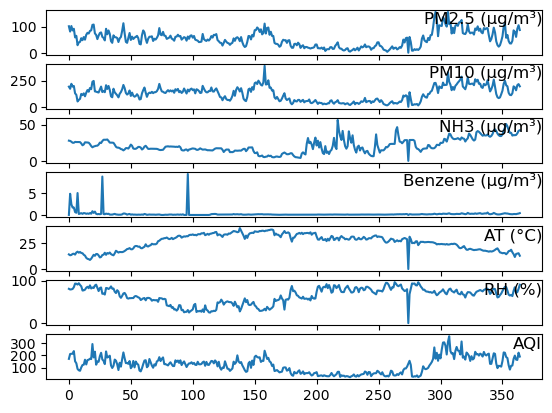

In [138]:
from pandas import read_csv
from matplotlib import pyplot

dataset = read_csv('filtered_data.csv', header=0, index_col=0)
values = dataset.values

groups = [0, 1, 2, 3, 4, 5, 6]
i = 1

pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [140]:
import numpy as np
import pandas as pd
from sklearn.preprocessing  import MinMaxScaler
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [141]:

data =pd.read_csv('/Users/shishir/Downloads/cs667-project/filtered_data.csv')

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data = data.sort_values('Timestamp').set_index('Timestamp')

features = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)','NH3 (µg/m³)','Benzene (µg/m³)','AT (°C)','RH (%)' ]
target=['AQI']
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(data[features])

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(data[target])

scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
scaled_target_df = pd.DataFrame(scaled_target, columns=target, index=data.index)

scaled_data = pd.concat([scaled_features_df, scaled_target_df], axis=1)
print(scaled_data.head())
scaled_data.to_csv('/Users/shishir/Downloads/cs667-project/scaled_data.csv', index=False)


def create_sequences(data, target, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i].values)  
        y.append(target[i])  
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features_df, scaled_target_df['AQI'].values)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

            PM2.5 (µg/m³)  PM10 (µg/m³)  NH3 (µg/m³)  Benzene (µg/m³)  \
Timestamp                                                               
2022-01-01       0.645587      0.491307     0.493284         0.001062   
2022-01-02       0.515857      0.439478     0.487098         0.516985   
2022-01-03       0.651203      0.561135     0.468187         0.260085   
2022-01-04       0.543935      0.491281     0.442559         0.180467   
2022-01-05       0.584264      0.507057     0.441499         0.181529   

             AT (°C)    RH (%)       AQI  
Timestamp                                 
2022-01-01  0.357626  0.837818  0.448071  
2022-01-02  0.336339  0.820987  0.566766  
2022-01-03  0.344853  0.824831  0.572700  
2022-01-04  0.368645  0.833974  0.572700  
2022-01-05  0.374906  0.877610  0.637982  
Shape of X: (335, 30, 6)
Shape of y: (335,)


In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(268, 30, 6) (268,)
(67, 30, 6) (67,)


In [143]:
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=1)


/opt/anaconda3/envs/my_new_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0628 - val_loss: 0.0218
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0177 - val_loss: 0.0186
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0186 - val_loss: 0.0210
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0182 - val_loss: 0.0165
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0143 - val_loss: 0.0152
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0130 - val_loss: 0.0136
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0161 - val_loss: 0.0141
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0149 - val_loss: 0.0156
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0148 - val_loss: 0.0138
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0134 - val_loss: 0.0137


In [144]:
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import concatenate

predictions = model.predict(X_test)


y_test_reshaped = y_test.reshape(-1, 1)
predictions_reshaped = predictions.reshape(-1, 1)


y_test_unscaled = scaler_target.inverse_transform(y_test_reshaped).flatten()
predictions_unscaled = scaler_target.inverse_transform(predictions_reshaped).flatten()
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled))
print(f"RMSE: {rmse}")



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
RMSE: 37.13269700744123


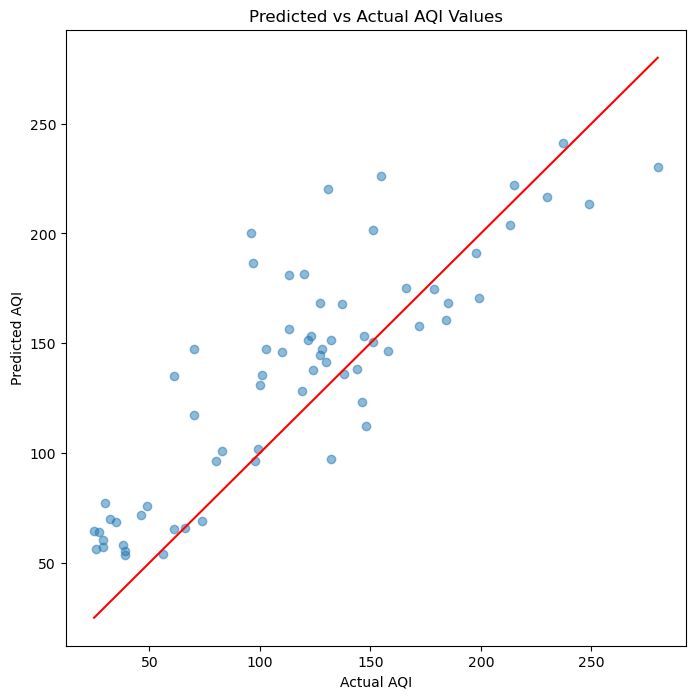

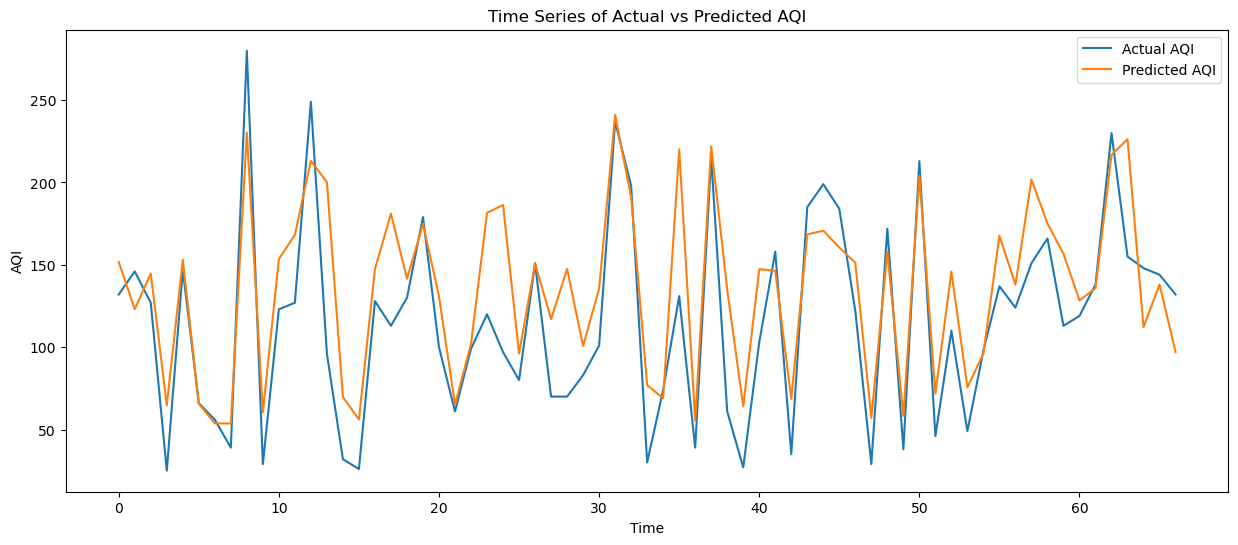

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test_unscaled, predictions_unscaled, alpha=0.5)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Predicted vs Actual AQI Values')
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], color='red')  # Diagonal line
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test_unscaled, label='Actual AQI')
plt.plot(predictions_unscaled, label='Predicted AQI')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.title('Time Series of Actual vs Predicted AQI')
plt.legend()
plt.show()


In [146]:
model.save('/Users/shishir/Downloads/cs667-project/aqi_prediction_model.keras')


In [147]:
import tensorflow as tf

model = tf.keras.models.load_model('/Users/shishir/Downloads/cs667-project/aqi_prediction_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

with open('/Users/shishir/Downloads/cs667-project/aqi_prediction_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/gy/hf59191j2hjdzmj4rv5264sr0000gn/T/tmpkdvhhkad/assets


INFO:tensorflow:Assets written to: /var/folders/gy/hf59191j2hjdzmj4rv5264sr0000gn/T/tmpkdvhhkad/assets


Saved artifact at '/var/folders/gy/hf59191j2hjdzmj4rv5264sr0000gn/T/tmpkdvhhkad'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 6), dtype=tf.float32, name='input_layer_12')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  13441703504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13441703888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13441708880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13441711376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13441708112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14097802128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14097796560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14097800592: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1731582616.675209 1296030 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1731582616.676011 1296030 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-11-14 16:40:16.676774: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/gy/hf59191j2hjdzmj4rv5264sr0000gn/T/tmpkdvhhkad
2024-11-14 16:40:16.677534: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-14 16:40:16.677539: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/gy/hf59191j2hjdzmj4rv5264sr0000gn/T/tmpkdvhhkad
2024-11-14 16:40:16.686162: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-14 16:40:16.728573: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/gy/hf59191j2hjdzmj4rv5264sr0000gn/T/tmpkdvhhkad
2024-11-14 16:40:16.744497: I tensorflow/cc/saved_model/loader.cc: